### Import

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

### Data Load

In [12]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

X = train.drop(columns=["ID", "Cancer"])
y = train["Cancer"]
X_test = test.drop(columns=["ID"])

### Data Preprocessing

In [13]:
categorical_cols = X.select_dtypes(include='object').columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

for col in categorical_cols:
    le = encoders[col]
    X_test[col] = X_test[col].map(lambda s: '<UNK>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<UNK>')
    X_test[col] = le.transform(X_test[col])

In [14]:
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_res_f, y_train_res_f = smote.fit_resample(X_train_f, y_train_f)

model_full = XGBClassifier(random_state=42, eval_metric='logloss')
model_full.fit(X_train_res_f, y_train_res_f)
_= model_full

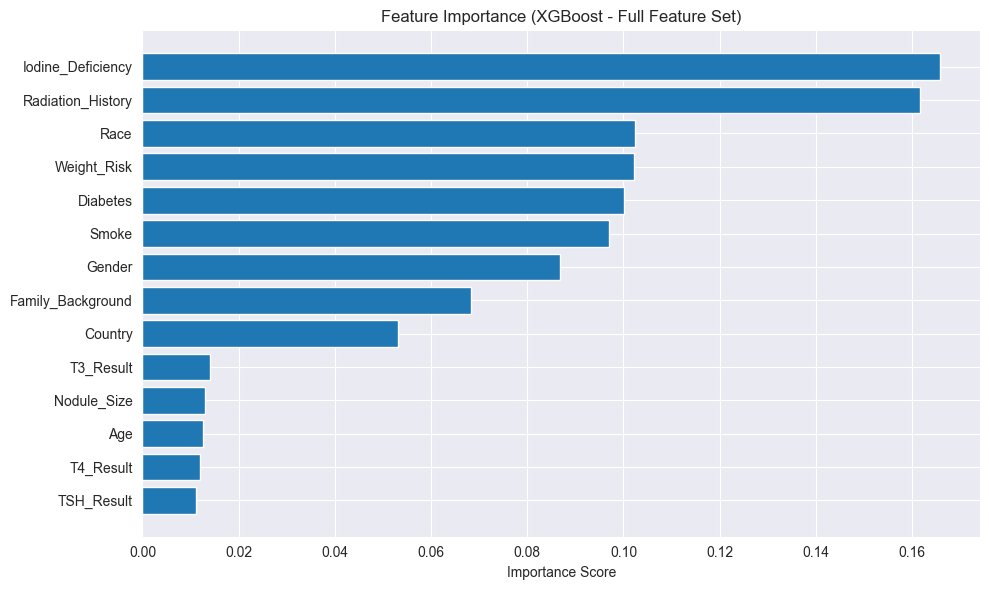

In [15]:
importances = model_full.feature_importances_
features = X_train_res_f.columns.tolist()

feature_importance = list(zip(features, importances))
feature_importance.sort(key=lambda x: x[1], reverse=True)

sorted_features = [f[0] for f in feature_importance]
sorted_importances = [f[1] for f in feature_importance]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (XGBoost - Full Feature Set)")
plt.barh(range(len(sorted_features)), sorted_importances[::-1], align="center")
plt.yticks(range(len(sorted_features)), sorted_features[::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [16]:
# 중요도 낮은 feature 제거 후 재정의
drop_features = ["T3_Result", "Nodule_Size", "Age", "T4_Result", "TSH_Result"]
X = X.drop(columns=drop_features)
X_test_dropped = X_test.drop(columns=drop_features)  # drop된 X_test는 따로 저장

### Train

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
lgbm = LGBMClassifier(random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

xgb.fit(X_train_res, y_train_res)
lgbm.fit(X_train_res, y_train_res)
cat.fit(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 61360, number of negative: 61360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 122720, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [18]:
xgb_val = xgb.predict_proba(X_val)[:, 1]
lgbm_val = lgbm.predict_proba(X_val)[:, 1]
cat_val = cat.predict_proba(X_val)[:, 1]

weights = {'xgb': 1.0, 'lgbm': 1.0, 'cat': 1.5}
total_weight = sum(weights.values())

ensemble_val = (
    xgb_val * weights['xgb'] +
    lgbm_val * weights['lgbm'] +
    cat_val * weights['cat']
) / total_weight

precisions, recalls, thresholds = precision_recall_curve(y_val, ensemble_val)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.4f}, Best F1 Score: {f1s[best_idx]:.4f}")

Best Threshold: 0.6093, Best F1 Score: 0.4629


### Predict

In [20]:
xgb_test = xgb.predict_proba(X_test_dropped)[:, 1]
lgbm_test = lgbm.predict_proba(X_test_dropped)[:, 1]
cat_test = cat.predict_proba(X_test_dropped)[:, 1]

ensemble_test = (
    xgb_test * weights['xgb'] +
    lgbm_test * weights['lgbm'] +
    cat_test * weights['cat']
) / total_weight

final_pred = (ensemble_test >= best_threshold).astype(int)

submission = pd.read_csv("./sample_submission.csv")
submission['Cancer'] = final_pred
submission.to_csv("submission.csv", index=False)
print("제출 파일이 저장되었습니다 →", "./submission.csv")

제출 파일이 저장되었습니다 → ./submission.csv
